In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, train_test_split, KFold
from sklearn.preprocessing   import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, recall_score, classification_report, confusion_matrix

# Questão 1

Considere o conjunto de dados disponível em californiabin.csv, organizado em 9 colunas, sendo as 8 primeiras colunas os atributos e a última coluna a saída. Os 8 atributos são usados na predição de preços de casas em distritos da Califórnia na década de 1990. A saída é binária: 0, para abaixo da mediana dos preços; 1, para acima da mediana dos preços. 

a. Considerando uma divisão de 80% dos padrões para treinamento e 20%
para teste, avalie modelos de classificação binária nos dados em questão.
Para tanto, use as abordagens abaixo:

* SVM: Escolha um kernel RBF e use grid-search para ajustar os hiperparâmetros C (valores $2^{−5}$, $2^{−3}$, $2^{−1}$, . . . , $2^{11}$, $2^{13}$, $2^{15}$) e γ (valores 2^{−15}, 2^{−13}, 2^{−11} , . . . , 2^{1} , 2^{2} , 2^{3}).
* Random Forest: Use grid-search para ajustar o número de classificadores base (valores 10, 20, . . ., 180, 190, 200) e a máxima profundidade (max depth, valores 4, 6, 8, 10 ou máxima (None no sklearn)).

In [3]:
data = pd.read_csv('californiabin.csv', header=None)
data.head(2)

,0,1,2,3,4,5,6,7,8
0,4.1685,20.0,6.700637,1.178344,745.0,2.372611,38.80,-121.15,1.0
1,2.8194,24.0,4.762500,1.020833,608.0,2.533333,36.75,-119.85,0.0


In [4]:
X, y = data.iloc[:, :8], data.iloc[:, 8]

Separando dados de treino e teste

In [5]:
xtrain, xtest, ytrain, ytest = train_test_split(X, y, train_size=0.8, random_state=42)

Escalonando caracteristicas

In [6]:
train_scaler = StandardScaler()
test_scaler = StandardScaler()

In [7]:
xtrain = train_scaler.fit_transform(xtrain)
xtest  = test_scaler.fit_transform(xtest)

Fazendo gridsearch para o `SVM`

In [8]:
params_svm = dict(
    C = (2.0 ** np.arange(-5, 16, 2)),
    gamma = (2.0 ** np.arange(-15, 4, 2)),
)

In [9]:
params_svm

{'C': array([3.1250e-02, 1.2500e-01, 5.0000e-01, 2.0000e+00, 8.0000e+00,
        3.2000e+01, 1.2800e+02, 5.1200e+02, 2.0480e+03, 8.1920e+03,
        3.2768e+04]),
 'gamma': array([3.05175781e-05, 1.22070312e-04, 4.88281250e-04, 1.95312500e-03,
        7.81250000e-03, 3.12500000e-02, 1.25000000e-01, 5.00000000e-01,
        2.00000000e+00, 8.00000000e+00])}

In [10]:
grid_svm = GridSearchCV(
    estimator =SVC(kernel='rbf'),
    param_grid=params_svm,
    scoring   =['accuracy', 'f1', 'recall'],
    cv        =KFold(n_splits=10, shuffle=True)   ,
    refit     ='accuracy'
)
grid_svm.fit(xtrain, ytrain)

,estimator,SVC()
,param_grid,"{'C': array([3.1250... 3.2768e+04]), 'gamma': array([3.0517...00000000e+00])}"
,scoring,"['accuracy', 'f1', ...]"
,n_jobs,None
,refit,'accuracy'
,cv,KFold(n_split... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,C,np.float64(512.0)


In [11]:
print(grid_svm.best_params_)

{'C': np.float64(512.0), 'gamma': np.float64(0.03125)}


In [12]:
print(grid_svm.best_score_)

0.8631249999999999


In [47]:
pd.DataFrame(grid_svm.cv_results_).iloc[:, 6:].head(2)

,params,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,split5_test_accuracy,split6_test_accuracy,split7_test_accuracy,split8_test_accuracy,...,split3_test_recall,split4_test_recall,split5_test_recall,split6_test_recall,split7_test_recall,split8_test_recall,split9_test_recall,mean_test_recall,std_test_recall,rank_test_recall
0,"{'C': 0.03125, 'gamma': 3.0517578125e-05}",0.49375,0.51875,0.5625,0.475,0.525,0.53125,0.50625,0.51875,0.51875,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,98
1,"{'C': 0.03125, 'gamma': 0.0001220703125}",0.49375,0.51875,0.5625,0.475,0.525,0.53125,0.50625,0.51875,0.51875,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,98


Gridsearch `Random Florest`

In [14]:
params_random = dict(
    n_estimators=np.arange(10, 200, 10),
    max_depth  = [None] + [i for i in range(4, 12, 2)]
)

In [15]:
params_random

{'n_estimators': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130,
        140, 150, 160, 170, 180, 190]),
 'max_depth': [None, 4, 6, 8, 10]}

In [16]:
grid_random = GridSearchCV(
    estimator =RandomForestClassifier(),
    param_grid=params_random,
    scoring   =['accuracy', 'f1', 'recall'],
    cv        =KFold(n_splits=10, shuffle=True)   ,
    refit     ='accuracy'
)
grid_random.fit(xtrain, ytrain)

,estimator,RandomForestClassifier()
,param_grid,"{'max_depth': [None, 4, ...], 'n_estimators': array([ 10, ...70, 180, 190])}"
,scoring,"['accuracy', 'f1', ...]"
,n_jobs,None
,refit,'accuracy'
,cv,KFold(n_split... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,np.int64(140)


In [17]:
print(grid_random.best_params_)

{'max_depth': None, 'n_estimators': np.int64(140)}


In [18]:
print(grid_random.best_score_)

0.881875


In [45]:
pd.DataFrame(grid_random.cv_results_).iloc[:, 6:].head(2)

,params,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,split5_test_accuracy,split6_test_accuracy,split7_test_accuracy,split8_test_accuracy,...,split3_test_recall,split4_test_recall,split5_test_recall,split6_test_recall,split7_test_recall,split8_test_recall,split9_test_recall,mean_test_recall,std_test_recall,rank_test_recall
0,"{'max_depth': None, 'n_estimators': 10}",0.84375,0.86875,0.85000,0.84375,0.9125,0.8375,0.86250,0.85625,0.83750,...,0.818182,0.868421,0.81250,0.802632,0.780488,0.795181,0.769231,0.810459,0.027756,81
1,"{'max_depth': None, 'n_estimators': 20}",0.83750,0.88125,0.86875,0.88750,0.8875,0.8625,0.85625,0.87500,0.85625,...,0.870130,0.881579,0.84375,0.776316,0.804878,0.819277,0.824176,0.838173,0.036639,54


b. Para cada modelo campeão, reporte os hiperparâmetros selecionados e as métricas de acurácia, revocação, precisão e F1-score nos dados de teste. Plote também a curva ROC e a curva Precision-Recall, reportando as áreas sob as curvas, i.e., AUROC e AUPRC.

In [20]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, auc, precision_recall_curve
)

`SVC`

In [21]:
melho_model_svc = grid_svm.best_estimator_
melho_model_svc

,C,np.float64(512.0)
,kernel,'rbf'
,degree,3
,gamma,np.float64(0.03125)
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [22]:
melho_model_svc.fit(xtrain, ytrain)

,C,np.float64(512.0)
,kernel,'rbf'
,degree,3
,gamma,np.float64(0.03125)
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [23]:
pred = melho_model_svc.predict(xtest)

In [24]:
print(classification_report(ytest, pred))

              precision    recall  f1-score   support

         0.0       0.76      0.87      0.81       186
         1.0       0.87      0.77      0.82       214

    accuracy                           0.81       400
   macro avg       0.82      0.82      0.81       400
weighted avg       0.82      0.81      0.82       400



In [25]:
acc  = accuracy_score(ytest,pred)
rec  = recall_score(ytest, pred)
prec = precision_score(ytest, pred)
f1   = f1_score(ytest, pred)


print(f'''
RESULTADO
Acuracia..: {acc}
Revocação.: {rec}
Precição..: {prec}
F1 Score..: {f1}
''')


RESULTADO
Acuracia..: 0.815
Revocação.: 0.7663551401869159
Precição..: 0.8723404255319149
F1 Score..: 0.8159203980099502



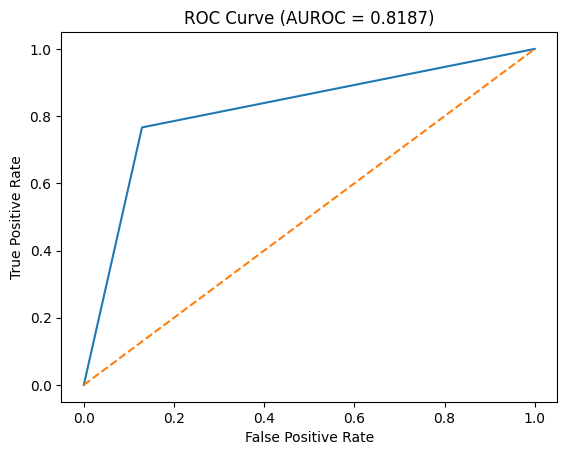

In [26]:
fpr, tpr, _ = roc_curve(ytest, pred)
auroc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0,1], [0,1], linestyle='--')
plt.title(f"ROC Curve (AUROC = {auroc:.4f})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

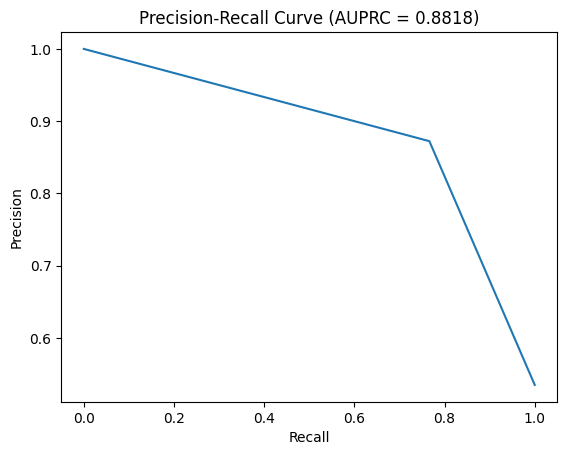

In [27]:
prec_curve, rec_curve, _ = precision_recall_curve(ytest, pred)
auprc = auc(rec_curve, prec_curve)

plt.figure()
plt.plot(rec_curve, prec_curve)
plt.title(f"Precision-Recall Curve (AUPRC = {auprc:.4f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

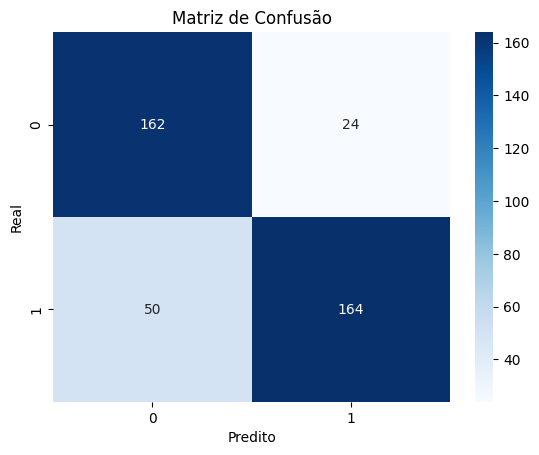

In [28]:
plt.figure()
sns.heatmap(confusion_matrix(ytest, pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("Matriz de Confusão")
plt.show()

`RandomFlorest`

In [31]:
melho_model_rnd = grid_random.best_estimator_

In [ ]:
melho_model_rnd.fit(xtrain, ytrain)

,C,np.float64(512.0)
,kernel,'rbf'
,degree,3
,gamma,np.float64(0.03125)
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [34]:
pred = melho_model_rnd.predict(xtest)

In [35]:
print(classification_report(ytest, pred))

              precision    recall  f1-score   support

         0.0       0.74      0.89      0.81       186
         1.0       0.88      0.73      0.80       214

    accuracy                           0.80       400
   macro avg       0.81      0.81      0.80       400
weighted avg       0.82      0.80      0.80       400



In [36]:
acc  = accuracy_score(ytest,pred)
rec  = recall_score(ytest, pred)
prec = precision_score(ytest, pred)
f1   = f1_score(ytest, pred)


print(f'''
RESULTADO
Acuracia..: {acc}
Revocação.: {rec}
Precição..: {prec}
F1 Score..: {f1}
''')


RESULTADO
Acuracia..: 0.8025
Revocação.: 0.7289719626168224
Precição..: 0.8813559322033898
F1 Score..: 0.7979539641943734



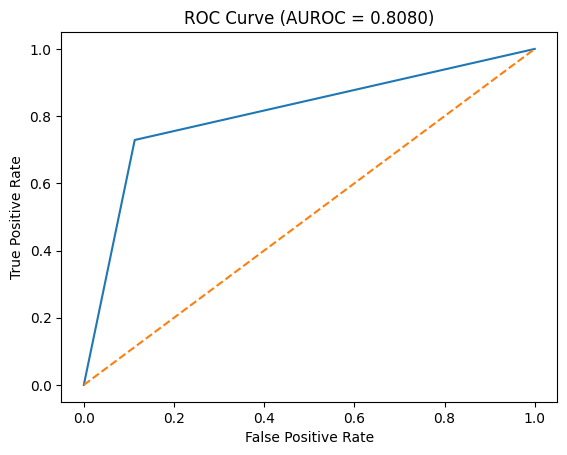

In [37]:
fpr, tpr, _ = roc_curve(ytest, pred)
auroc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0,1], [0,1], linestyle='--')
plt.title(f"ROC Curve (AUROC = {auroc:.4f})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

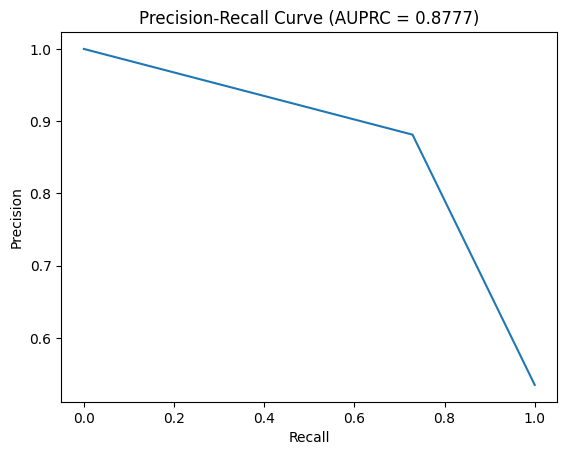

In [38]:
prec_curve, rec_curve, _ = precision_recall_curve(ytest, pred)
auprc = auc(rec_curve, prec_curve)

plt.figure()
plt.plot(rec_curve, prec_curve)
plt.title(f"Precision-Recall Curve (AUPRC = {auprc:.4f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

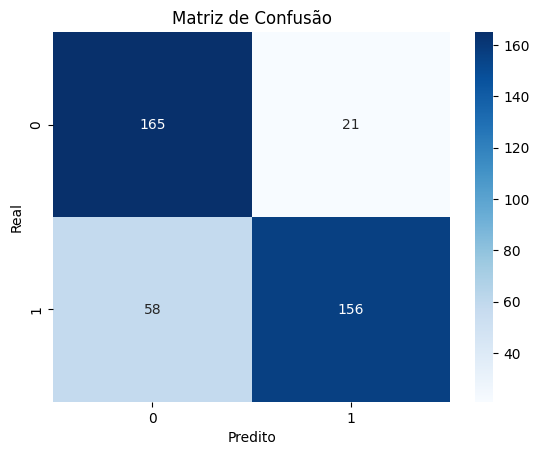

In [39]:
plt.figure()
sns.heatmap(confusion_matrix(ytest, pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("Matriz de Confusão")
plt.show()